# Red Neuronal sin TensorFlow/Keras usando solo Matemáticas

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('mnist_train.csv')

In [ ]:
# Convertir los datos a un array de NumPy
data = np.array(data)
m, n = data.shape

# Barajar los datos aleatoriamente
np.random.shuffle(data)

# Dividir los datos en conjuntos de desarrollo (validación) y entrenamiento
data_dev = data[0:1000].T
Y_dev = data_dev[0]  # Etiquetas
X_dev = data_dev[1:n]  # Características
X_dev = X_dev / 255.  # Normalizar los datos

data_train = data[1000:m].T
Y_train = data_train[0]  # Etiquetas
X_train = data_train[1:n]  # Características
X_train = X_train / 255.  # Normalizar los datos
_, m_train = X_train.shape


In [ ]:
Y_train

array([7, 9, 3, ..., 3, 5, 2])

In [ ]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    
    return W1, b1, W2, b2

# Definir las funciones de activación ReLU y softmax
def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

# Definir las derivadas de las funciones de activación
def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

# Implementar la propagación hacia adelante
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Implementar la propagación hacia atrás
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, lambd):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m_train * dZ2.dot(A1.T) + (lambd / m_train) * W2
    db2 = 1 / m_train * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m_train * dZ1.dot(X.T) + (lambd / m_train) * W1
    db1 = 1 / m_train * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

# Actualizar los parámetros usando gradiente descendente con momentum
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, beta, vW1, vb1, vW2, vb2):
    vW1 = beta * vW1 + (1 - beta) * dW1
    vb1 = beta * vb1 + (1 - beta) * db1
    vW2 = beta * vW2 + (1 - beta) * dW2
    vb2 = beta * vb2 + (1 - beta) * db2
    W1 = W1 - alpha * vW1
    b1 = b1 - alpha * vb1
    W2 = W2 - alpha * vW2
    b2 = b2 - alpha * vb2
    return W1, b1, W2, b2, vW1, vb1, vW2, vb2


In [ ]:
# Obtener predicciones del modelo entrenado
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

# Implementar el algoritmo de gradiente descendente
def gradient_descent(X, Y, alpha, iterations, lambd, beta):
    W1, b1, W2, b2 = init_params()
    vW1, vb1, vW2, vb2 = np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2)
    losses = []
    accuracies = []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, lambd)
        W1, b1, W2, b2, vW1, vb1, vW2, vb2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha, beta, vW1, vb1, vW2, vb2)
        if i % 10 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            accuracies.append(accuracy)
            loss = np.mean(-np.log(A2[Y, np.arange(A2.shape[1])])) + (lambd / (2 * m_train)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
            losses.append(loss)
            print(f'Iteration {i}: Loss = {loss:.4f}, Accuracy = {accuracy * 100:.2f}%')
    return W1, b1, W2, b2, losses, accuracies

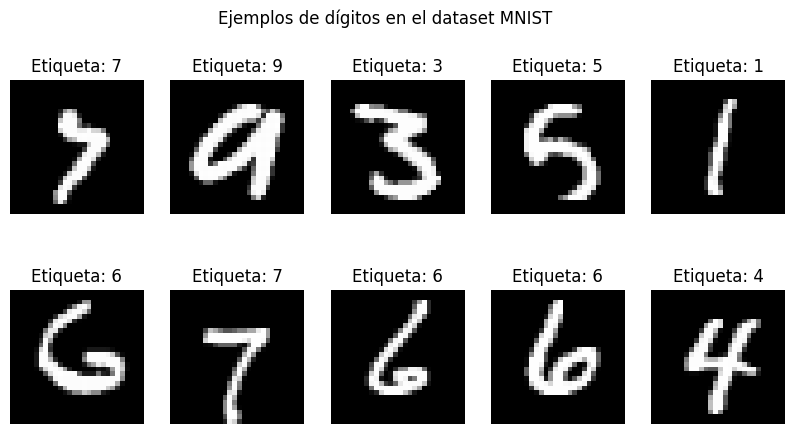

In [ ]:
# Visualizar algunos ejemplos del dataset MNIST
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('Ejemplos de dígitos en el dataset MNIST')

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[:, i].reshape(28, 28) * 255, cmap='gray')
    ax.set_title(f'Etiqueta: {Y_train[i]}')
    ax.axis('off')

plt.show()

In [ ]:
# Entrenar el modelo y obtener pérdidas y precisiones
W1, b1, W2, b2, losses, accuracies = gradient_descent(X_train, Y_train, 0.1, 500, 0.01, 0.9)

Iteration 0: Loss = 2.3307, Accuracy = 10.92%
Iteration 10: Loss = 2.2264, Accuracy = 18.82%
Iteration 20: Loss = 2.1080, Accuracy = 25.11%
Iteration 30: Loss = 1.9741, Accuracy = 28.27%
Iteration 40: Loss = 1.8360, Accuracy = 35.61%
Iteration 50: Loss = 1.6878, Accuracy = 42.82%
Iteration 60: Loss = 1.5290, Accuracy = 48.21%
Iteration 70: Loss = 1.3697, Accuracy = 56.07%
Iteration 80: Loss = 1.2214, Accuracy = 68.50%
Iteration 90: Loss = 1.0911, Accuracy = 72.86%
Iteration 100: Loss = 0.9820, Accuracy = 75.17%
Iteration 110: Loss = 0.8924, Accuracy = 76.73%
Iteration 120: Loss = 0.8202, Accuracy = 78.02%
Iteration 130: Loss = 0.7621, Accuracy = 79.14%
Iteration 140: Loss = 0.7148, Accuracy = 80.21%
Iteration 150: Loss = 0.6759, Accuracy = 81.11%
Iteration 160: Loss = 0.6434, Accuracy = 81.95%
Iteration 170: Loss = 0.6158, Accuracy = 82.62%
Iteration 180: Loss = 0.5920, Accuracy = 83.27%
Iteration 190: Loss = 0.5713, Accuracy = 83.90%
Iteration 200: Loss = 0.5532, Accuracy = 84.48%
Ite

In [ ]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Ejemplos:

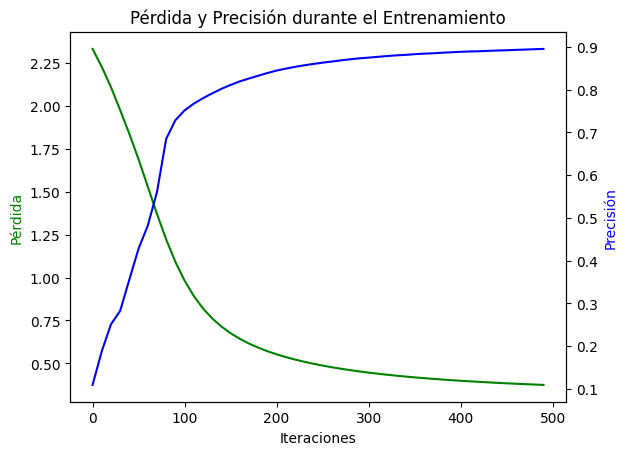

In [ ]:
# Graficar la pérdida y la precisión a lo largo del entrenamiento
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(0, 500, 10), losses, 'g-')
ax2.plot(range(0, 500, 10), accuracies, 'b-')

ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Pérdida', color='g')
ax2.set_ylabel('Precisión', color='b')

plt.title('Pérdida y Precisión durante el Entrenamiento')
plt.show()

Prediction:  [7]
Label:  7


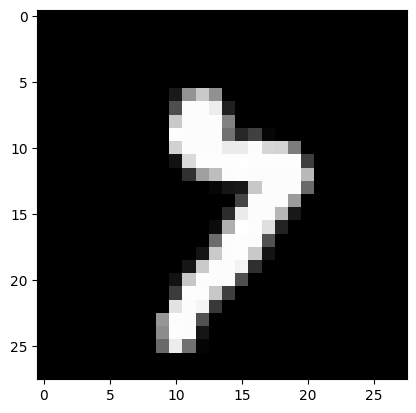

Prediction:  [9]
Label:  9


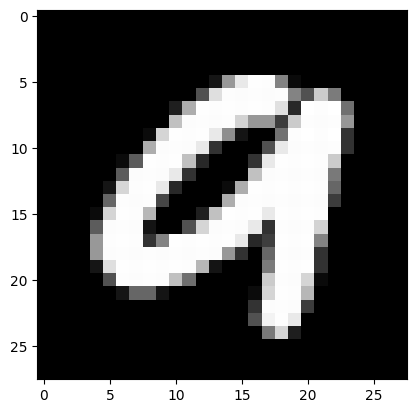

Prediction:  [3]
Label:  3


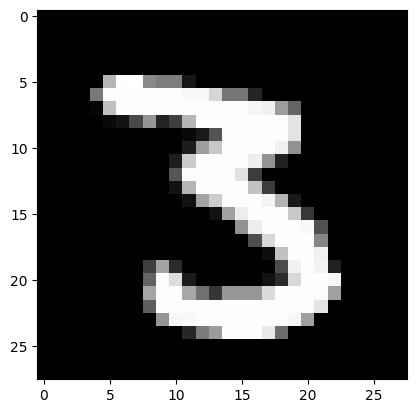

Prediction:  [8]
Label:  5


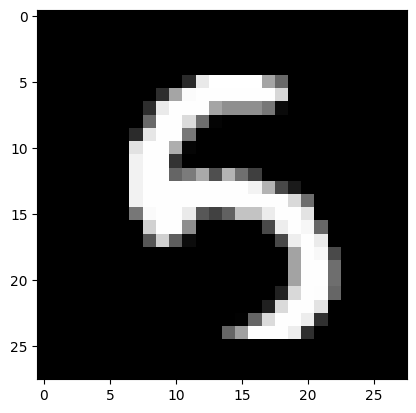

In [ ]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [ ]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.892